# Model Inference
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hsimonfroy/benchmark-field-level/blob/main/examples/infer_model.ipynb)

Infer from a cosmological model via MCMC samplers.

In [2]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.9' # NOTE: jax preallocates GPU (default 75%)
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, grad, debug, tree, lax
jconfig.update("jax_enable_x64", True)
print(jdevices())

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload , Path

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname
#!jupyter nbconvert --to python /global/u1/h/hsimfroy/workspace/montecosmo_proj/src/montecosmo/tests/infer_model2.ipynb

save_dir = Path("./scratch")
# save_dir = Path("/feynman/home/dphp/hs276503/scratch/png/kaiser_test21")
# save_dir = Path("/pscratch/sd/h/hsimfroy/png/kaiser_test21")
save_path = save_dir / "test"
save_dir.mkdir(parents=True, exist_ok=True)

[cuda(id=0)]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
feynmangpu04.cluster.local


## Experimental setup
### Instantiate model
We can see how the model is actually reparametrized.

###  Generate an observation and condition the model on it
We can see all the free parameters in the model, that we will subsequently sample.

In [ ]:
# overwrite = False
overwrite = True
truth0 = {
    'Omega_m': 0.3, 
    # 'Omega_c': 0.3-0.04860,
    # 'Omega_b': 0.04860,
    'sigma8': 0.8,
    'b1': 1.,
    'b2': 0.,
    'bs2': 0.,
    'bn2': 0.,
    'bnp': 0.,
    'fNL': 0.,
    'alpha_iso': 1.,
    'alpha_ap': 1.,
    'ngbars': 0.001,
    }
cell_budget = 128**3
padding = 0.2
# padding = None
mesh_length = round(cell_budget**(1/3))

if not os.path.exists(save_dir / "truth.npz") or overwrite:
    print("Generate truth...")
    model = FieldLevelModel(**default_config | 
                            {'mesh_shape': 3*(mesh_length,), 
                            'cell_length': 2000 / mesh_length, 
                            'box_center': (0.,0.,2000.), # in Mpc/h
                            'box_rotvec': (0.,0.,0.,), # rotation vector in radians
                            'evolution': 'lpt',
                            'a_obs': .5, # light-cone if None
                            'curved_sky': True, # curved vs. flat sky
                            'ap_auto': None, # parametrized AP vs. auto AP
                            'selection': padding, # if float, padded fraction, if str or Path, path to window mesh file
                            'paint_order':2, # order of interpolation kernel
                            'init_oversamp':1., # initial mesh 1D oversampling factor
                            'ptcl_oversamp':1., # particle grid 1D oversampling factor
                            'paint_oversamp':1., # painted mesh 1D oversampling factor
                            'interlace_order':1, # interlacing order
                            'n_rbins': 1,
                            'k_cut': jnp.inf,
                            } )

    # fits_path = Path("/home/nfs/bao/AbacusSummit_v4_2/mock0/LRG_complete_SGC_1_clustering.ran.fits") # Feynman
    # # fits_path = Path("/dvs_ro/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit_v4_2/mock0/LRG_complete_SGC_1_clustering.ran.fits") # Perlmutter
    # model.add_selection(fits_path, cell_budget, padding, save_dir / "selection.npy")
    
    truth = model.predict(samples=truth0, hide_base=False, hide_samp=False, from_base=True)
    model.save(save_dir / "model.yaml")    
    jnp.savez(save_dir / "truth.npz", **truth)

    model2 = FieldLevelModel(**model.asdict() | {
                                                # 'evolution': 'kaiser',
                                                # 'init_oversamp':1., # initial mesh 1D oversampling factor
                                                # 'ptcl_oversamp':1., # particle grid 1D oversampling factor
                                                # 'paint_oversamp':1., # painted mesh 1D oversampling factor
                                                #  'k_cut': np.inf,
                                                 })
    # model2 = FieldLevelModel(**model.asdict() | {'evolution': 'lpt', 'lpt_order':1, 'k_cut': 0.1,})
    # model2 = FieldLevelModel(**model.asdict() | {'ap_auto': None})
    # model2 = FieldLevelModel(**model.asdict() | {'paint_order': 3, 'oversampling': 1.})
    
    # model2 = FieldLevelModel(**model.asdict())
    # model2.latents['Omega_m']['loc_fid'] = 0.3
    # model2.__post_init__()

    truth2 = model2.predict(samples=truth0, hide_base=False, hide_samp=False, from_base=True)
    # truth2 = model2.predict(samples=truth0 | {'Omega_m': 0.3111}, hide_base=False, hide_samp=False, from_base=True)
    # truth2 = model2.predict(samples=truth0 | {'alpha_iso':0.95}, hide_base=False, hide_samp=False, from_base=True)

    model2.save(save_dir / "model2.yaml")    
    jnp.savez(save_dir / "truth2.npz", **truth2)
else:
    model = FieldLevelModel.load(save_dir / "model.yaml")
    truth = np.load(save_dir / "truth.npz")

    model2 = FieldLevelModel.load(save_dir / "model2.yaml")
    truth2 = np.load(save_dir / "truth2.npz")

print(model)
# model.render()
# print("logpdf(truth) =", (model.logpdf)(truth))
delta_obs = model.count2delta(truth['obs'])

# print(model2)
# model2.render("bnet.png")
delta_obs2 = model2.count2delta(truth2['obs'])

Generate truth...


2025-10-11 20:31:34.530461: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# CONFIG
{'a_obs': 0.5,
 'ap_auto': None,
 'box_center': array([   0.,    0., 2000.]),
 'box_rotvec': array([0., 0., 0.]),
 'cell_length': 15.625,
 'curved_sky': True,
 'evolution': 'lpt',
 'init_oversamp': 1.75,
 'init_power': None,
 'interlace_order': 2,
 'k_cut': 0.20106192982974677,
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3137721,
                         'loc_fid': 0.3137721,
                         'low': 0.05,
                         'scale': 0.5,
                         'scale_fid': 0.01},
             'alpha_ap': {'group': 'ap',
                          'high': inf,
                          'label': '{\\alpha_\\mathrm{AP}}',
                          'loc': 1.0,
                          'loc_fid': 1.0,
                          'low': 0.0,
                          'scale': 0.1,
                          'scale_fid': 0.01},
             'alpha_iso':

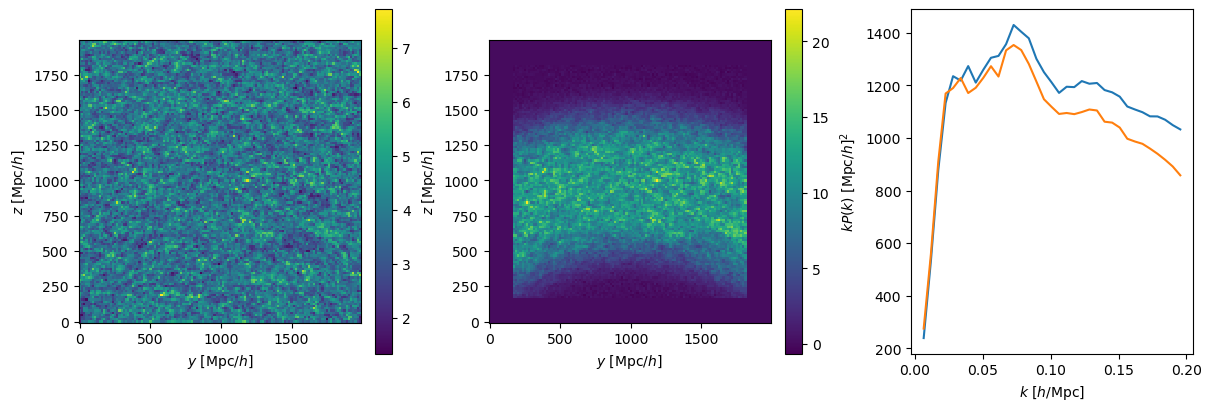

In [3]:
from montecosmo.plot import plot_mesh, plot_pow

axis = 0
ind = .1
ind = .5
# ind = np.array([6])
# ind = np.array([22])
count_obs  = model.masked2mesh(truth['obs'])
count_obs2 = model2.masked2mesh(truth2['obs'])

plt.figure(figsize=(12, 4), layout='constrained')
plt.subplot(131)
plot_mesh(count_obs, model.box_shape, ind, axis)
plt.colorbar()

plt.subplot(132)
plot_mesh(count_obs2, model2.box_shape, ind, axis)
plt.colorbar()

plt.subplot(133)
kpow = model.spectrum(delta_obs)
kpow2 = model2.spectrum(delta_obs2)

ks, pows = kpow2
# ks = ks * truth2['alpha_iso']
# pows = pows / truth2['alpha_iso']**3
kpow2 = ks, pows
log = False
plot_pow(*kpow, log=log);
plot_pow(*kpow2, log=log);
# plt.savefig("./figs_png/omega/apauto1_noise00.png", dpi=300, bbox_inches='tight')

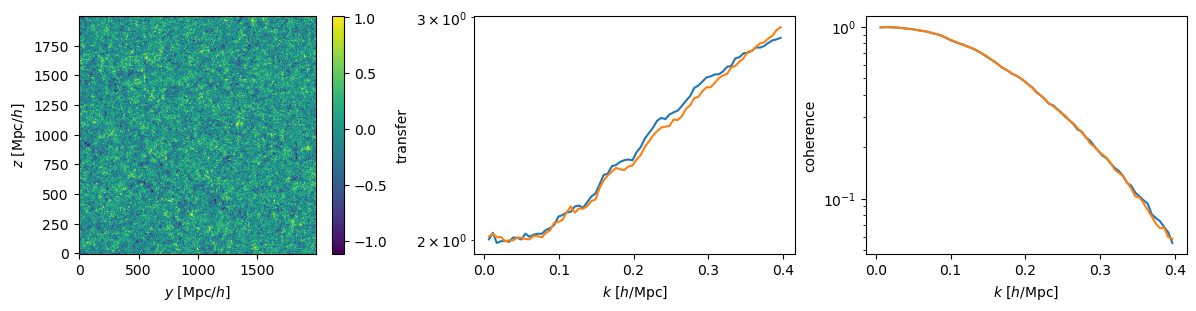

In [ ]:
from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh
kptc = model.powtranscoh(truth['init_mesh'], delta_obs)
kptc2 = model2.powtranscoh(truth2['init_mesh'], delta_obs2)

plt.figure(figsize=(12, 3), layout='constrained')
plot_powtranscoh(*kptc)
plot_powtranscoh(*kptc2)
plt.subplot(131)
plt.gca().clear()
ind = .5
plot_mesh(count_obs2-count_obs, model.box_shape, ind, axis)
plt.colorbar();
# plt.savefig("oversamp1_interlace2_vs_1__kcut.png", dpi=300, bbox_inches='tight')
# plt.savefig("interlacing1_oversamp1_vs_0_kcut.png", dpi=300, bbox_inches='tight')

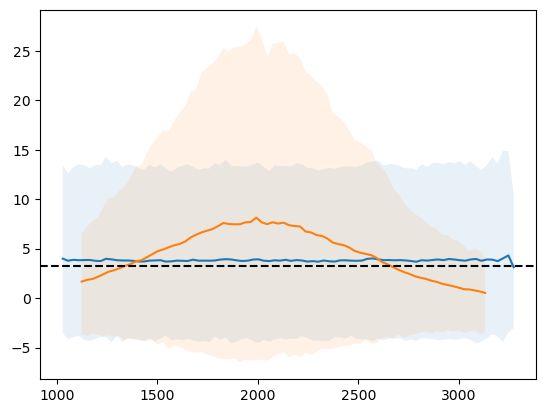

In [82]:
from montecosmo.bdec import credint

rnavg = model.distr_radial(truth['obs'])
rnavg2 = model2.distr_radial(truth2['obs'])
ravg, ncredint = model.distr_radial(truth['obs'], aggr_fn=credint)
ravg2, ncredint2 = model2.distr_radial(truth2['obs'], aggr_fn=credint)

plt.plot(*rnavg)
plt.plot(*rnavg2)
plt.axhline(model.count_fid, color='k', linestyle='--', label="mean")
plt.fill_between(ravg, *ncredint.T, alpha=0.1)
plt.fill_between(ravg2, *ncredint2.T, alpha=0.1)

In [9]:
# from montecosmo.nbody import rfftk, a2f
# from montecosmo.bricks import tophysical_mesh
# from montecosmo.utils import safe_div

# init_mesh = truth['init_mesh']
# bE = 2.
# los, a = tophysical_mesh(model.box_center, model.box_rot, model.box_shape, model.mesh_shape,
#                     model.cosmo_fid, model.a_obs, model.curved_sky)

# kvec = rfftk(model.mesh_shape)
# kmesh = sum(kk**2 for kk in kvec)**.5 # in cell units

# mu_delta = jnp.stack([jnp.fft.irfftn(
#         safe_div(kvec[i] * init_mesh, kmesh)
#         ) for i in range(3)], axis=-1)
# mu_delta = (mu_delta * los).sum(-1)
# mu_delta = jnp.fft.rfftn(mu_delta)

# mu2_delta = jnp.stack([jnp.fft.irfftn(
#         safe_div(kvec[i] * mu_delta, kmesh)
#         ) for i in range(3)], axis=-1)
# mu2_delta = (mu2_delta * los).sum(-1)

# delta = (bE * jnp.fft.irfftn(init_mesh) + a2f(model.cosmo_fid, a) * mu2_delta)




# from jax.scipy.special import sph_harm
# # from jax.scipy.special import sph_harm_y # JAX >= 0.6.1
# pos = model.pos_mesh()
# mu2_delta = jnp.fft.irfftn(init_mesh) / 3
# for m in range(-2, 3):
#     sph_harm(m, 2)

## Perform the inference

### Warmup the field only

kai
kai


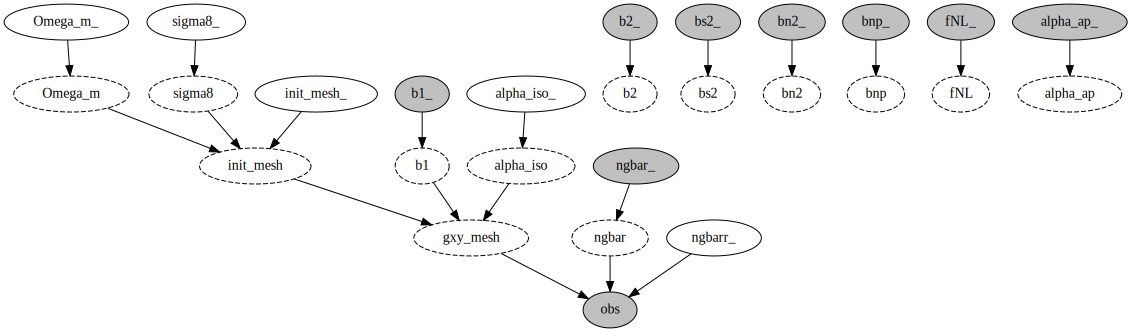

In [10]:
n_samples, n_runs, n_chains, tune_mass = 128, 16, 4, True
# overwrite = True
overwrite = False

params_init = jit(vmap(partial(model.kaiser_post, delta_obs=delta_obs, scale_field=1/10)))(jr.split(jr.key(45), n_chains))    
params_init2 = jit(vmap(partial(model2.kaiser_post, delta_obs=delta_obs2)))(jr.split(jr.key(45), n_chains))

if not os.path.exists(save_path+"_warm_state.p") or overwrite:
    print("Warming up...")
    model.reset()
    # model.condition({'obs': truth['obs']} | model.loc_fid, from_base=True)
    model.condition({'obs': truth['obs']} | model.loc_fid | {'ngbarr_':jnp.zeros(17),}, from_base=True)
    model.block()

    from montecosmo.samplers import get_mclmc_warmup
    warmup_fn = jit(vmap(get_mclmc_warmup(model.logpdf, n_steps=2**14, config=None, 
                                desired_energy_var=1e-6, diagonal_preconditioning=False)))
    state, config = warmup_fn(jr.split(jr.key(43), n_chains), {k: params_init[k] for k in ['init_mesh_']})
    pdump(state, save_path+"_warm_state.p")
    pdump(config, save_path+"_warm_conf.p")
else:
    state = pload(save_path+"_warm_state.p")
    config = pload(save_path+"_warm_conf.p")

# obs = ['obs','b1','b2','bs2','bn2','bnp','fNL','ngbar','alpha_iso','alpha_ap']
# obs = ['obs','Omega_m','sigma8','b1','b2','bs2','bn2','ngbar']
# obs = ['obs','b1','b2','bs2','bn2','fNL','ngbar']
# obs = ['obs','b2','bs2','bn2','fNL','ngbar','alpha_iso','alpha_ap']
# obs = ['obs','fNL','ngbar','alpha_iso','alpha_ap']
# obs = ['obs','fNL','bnp','ngbar','alpha_iso','alpha_ap']
# obs = ['obs','fNL','b2','bs2','bn2','bnp','alpha_iso','alpha_ap']
# obs = ['obs','fNL','b1','b2','bs2','bn2','bnp','ngbar','sigma8','alpha_ap']
obs = ['obs','fNL','b1','b2','bs2','bn2','bnp','ngbar','alpha_ap']
# obs = ['obs','fNL','b1','b2','bs2','bn2','bnp','ngbar','alpha_iso','alpha_ap']

# obs = ['obs','fNL','b2','bs2','bn2','bnp','ngbar','alpha_iso','alpha_ap']
# obs = ['obs','alpha_iso','alpha_ap']
# obs = ['obs', 'ngbar']
obs = {k: truth[k] for k in obs}

model.reset()
model.condition(obs, from_base=True)
# model.condition(obs | {'ngbarr_': jnp.zeros(17)}, from_base=True)
model.render()
model.block()

params_warm = params_init | state.position
params_warm = {k: params_warm[k] for k in params_warm.keys() - model.data.keys()}

params_warm |= {'ngbarr_': jnp.zeros((n_chains, 17))}

In [11]:
from montecosmo.plot import plot_pow, plot_trans, plot_coh, plot_powtranscoh
from montecosmo.bricks import lin_power_interp

mesh_true = jnp.fft.irfftn(truth['init_mesh'])
kpow_true = model.spectrum(mesh_true)
kpow_fid = kpow_true[0], lin_power_interp(model.cosmo_fid)(kpow_true[0])
kptc_obs = model.powtranscoh(mesh_true, delta_obs)
kptcs_init = vmap(lambda x: model.powtranscoh(mesh_true, model.reparam(x, fourier=False)['init_mesh']))(params_init)
kptcs_init2 = vmap(lambda x: model2.powtranscoh(mesh_true, model2.reparam(x, fourier=False)['init_mesh']))(params_init2)
kptcs_warm = vmap(lambda x: model.powtranscoh(mesh_true, model.reparam(x, fourier=False)['init_mesh']))(params_warm)

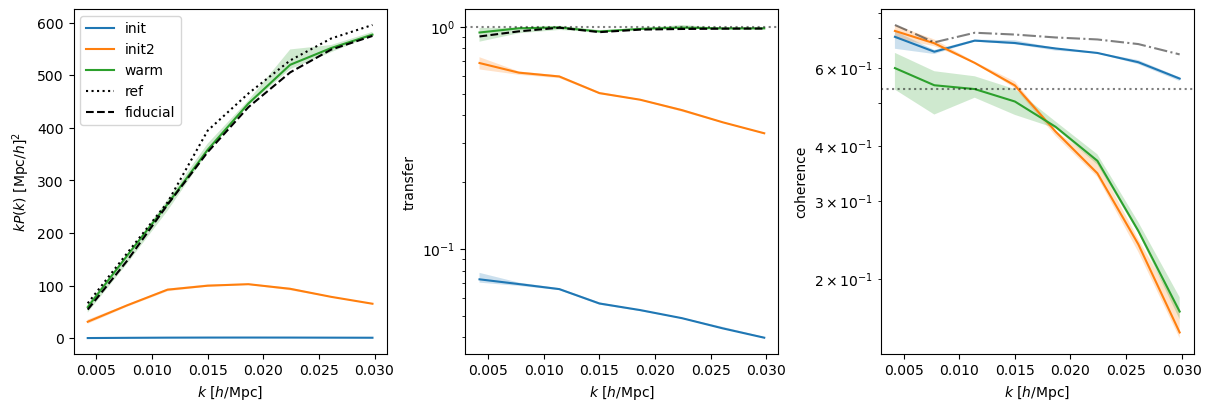

In [12]:
prob = 0.95

plt.figure(figsize=(12, 4), layout='constrained')
def plot_kptcs(kptcs, label=None):
    plot_powtranscoh(*kptcs, fill=prob)
    plot_powtranscoh(*tree.map(lambda x: jnp.median(x, 0), kptcs), label=label)

plot_kptcs(kptcs_init, label='init')
plot_kptcs(kptcs_init2, label='init2')
plot_kptcs(kptcs_warm, label='warm')

plt.subplot(131)
plot_pow(*kpow_true, 'k:', label='ref')
plot_pow(*kpow_fid, 'k--', label='fiducial')
plt.legend()
plt.subplot(132)
plot_trans(kpow_true[0], (kpow_fid[1] / kpow_true[1])**.5, 'k--', label='fiducial')
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plot_coh(kptc_obs[0], kptc_obs[3], 'k-.', alpha=0.5, label='obs');
plt.axhline(model.wind_mesh.mean(), linestyle=':', color='k', alpha=0.5)
plt.savefig(save_path+f'_init_warm.png')   

### Warmup all parameters and run

In [13]:
params_warm.keys()

dict_keys(['alpha_iso_', 'init_mesh_', 'sigma8_', 'Omega_m_', 'ngbarr_'])

In [14]:
# jconfig.update("jax_debug_nans", True)
from tqdm import tqdm
from montecosmo.samplers import get_mclmc_warmup, get_mclmc_run
from blackjax.adaptation.mclmc_adaptation import MCLMCAdaptationState
overwrite = True
# overwrite = False

params_warm['init_mesh_']  = jnp.broadcast_to(truth['init_mesh_'], jnp.shape(params_warm['init_mesh_']))

if not os.path.exists(save_path+"_warm2_state.p") or overwrite:
    print("Warming up...")
    warmup_fn = jit(vmap(get_mclmc_warmup(model.logpdf, n_steps=2**13, config=None, # 2**13
                                        desired_energy_var=2e-7, diagonal_preconditioning=tune_mass)))
    state, config = warmup_fn(jr.split(jr.key(43), n_chains), params_warm)

    print("ss: ", config.step_size)

    eval_per_ess = 1e3
    ss = jnp.median(config.step_size)
    config = MCLMCAdaptationState(L=0.4 * eval_per_ess/2 * ss, 
                                step_size=ss, 
                                inverse_mass_matrix=jnp.median(config.inverse_mass_matrix, 0))
    config = tree.map(lambda x: jnp.broadcast_to(x, (n_chains, *jnp.shape(x))), config)
    
    pdump(state, save_path+"_warm2_state.p")
    pdump(config, save_path+"_conf.p")
    start = 1

    print("ss: ", config.step_size[0])
    print("L: ", config.L[0])
    from jax.flatten_util import ravel_pytree
    flat, unrav_fn = ravel_pytree(tree.map(lambda x:x[0], state.position))
    print("inv_mm:", unrav_fn(config.inverse_mass_matrix[0]))
    print(tree.map(vmap(lambda x: jnp.isnan(x).sum()), state.position))
    

elif not os.path.exists(save_path+"_last_state.p") or overwrite:
    state = pload(save_path+"_warm2_state.p")
    config = pload(save_path+"_conf.p")
    start = 1

else:
    state = pload(save_path+"_last_state.p")
    config = pload(save_path+"_conf.p")
    start = 100 ###########


print("Running...")
run_fn = jit(vmap(get_mclmc_run(model.logpdf, n_samples, thinning=64, progress_bar=False)))
seed = jr.key(42)

end = start + n_runs - 1
for i_run in tqdm(range(start, end + 1)):
    print(f"run {i_run}/{end}")
    seed, run_seed = jr.split(seed, 2)
    state, samples = run_fn(jr.split(run_seed, n_chains), state, config)
    
    print("MSE per dim:", jnp.mean(samples['mse_per_dim'], 1), '\n')
    jnp.savez(save_path+f"_{i_run}.npz", **samples)
    pdump(state, save_path+"_last_state.p")



Warming up...
kai
kai
kai
kai
kai


2025-06-25 19:16:33.751121: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce.248060 = f64[262144]{0} reduce(f64[262144,3]{1,0} %constant.71481, f64[] %constant.243978), dimensions={1}, to_apply=%region_675.114730, metadata={op_name="jit(<unnamed function>)/jit(main)/vmap(while)/body/reduce_prod[axes=(1,)]" source_file="/feynman/home/dphp/hs276503/workspace/montecosmo_proj/src/montecosmo/montecosmo/nbody.py" source_line=202}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-06-25 19:16:33.751681: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.0

Perform 7022.0 adaptation steps
ss:  [33.39979786 27.11571943 33.93744956 26.5132343 ]
ss:  30.25775864547915
L:  6051.55172909583
inv_mm: {'Omega_m_': Array(0.39312372, dtype=float64), 'alpha_iso_': Array(0.00123444, dtype=float64), 'init_mesh_': Array([[[ 0.81469739,  4.35104607,  6.51357604, ...,  6.69036711,
          7.12310419,  9.76620186],
        [ 3.17728799,  4.7328482 ,  6.32299865, ...,  9.85189605,
          4.87997274,  4.6744975 ],
        [ 2.60690799,  6.15295795,  3.63964977, ...,  4.51021137,
          5.9534855 ,  6.52323546],
        ...,
        [ 4.31432115,  4.18996155,  6.37394863, ...,  5.86839946,
          6.18588018,  5.47968885],
        [ 6.11004666,  4.48428347,  3.75394792, ...,  5.90523525,
          7.73430446,  7.93050643],
        [ 7.3836877 ,  4.54217767,  6.24145933, ..., 11.39899671,
          7.31208056,  3.36214034]],

       [[ 2.12825196,  5.26883252,  8.37089833, ...,  6.49385461,
         15.2815424 ,  4.85375288],
        [ 3.94792929,  

  0%|          | 0/16 [00:00<?, ?it/s]

run 1/16
kai
kai


  6%|▋         | 1/16 [08:12<2:03:13, 492.92s/it]

MSE per dim: [1.50896106e-07 1.79444259e-07 2.45573155e-07 2.16211548e-07] 

run 2/16
MSE per dim: [2.19309731e-07 2.05356384e-07 1.32974353e-07 2.11201979e-07] 



 12%|█▎        | 2/16 [13:49<1:33:34, 401.01s/it]

run 3/16
MSE per dim: [1.35615158e-07 1.82963060e-07 2.76405961e-07 1.97765079e-07] 



 19%|█▉        | 3/16 [19:25<1:20:29, 371.48s/it]

run 4/16
MSE per dim: [2.50383186e-07 2.02975136e-07 1.50923502e-07 1.80926549e-07] 



 25%|██▌       | 4/16 [25:02<1:11:32, 357.73s/it]

run 5/16
MSE per dim: [2.01624564e-07 2.21950528e-07 1.19234159e-07 1.85404064e-07] 



 31%|███▏      | 5/16 [30:39<1:04:11, 350.12s/it]

run 6/16
MSE per dim: [1.64953885e-07 2.48079436e-07 1.75713820e-07 1.64734169e-07] 



 38%|███▊      | 6/16 [36:15<57:35, 345.55s/it]  

run 7/16
MSE per dim: [1.76001014e-07 1.68473668e-07 9.50805674e-08 2.10948364e-07] 



 44%|████▍     | 7/16 [41:52<51:23, 342.61s/it]

run 8/16
MSE per dim: [1.36150361e-07 1.32662704e-07 1.77754882e-07 1.44460931e-07] 



 50%|█████     | 8/16 [47:29<45:26, 340.83s/it]

run 9/16
MSE per dim: [1.64868712e-07 2.07990044e-07 1.39135076e-07 1.68290264e-07] 



 56%|█████▋    | 9/16 [53:05<39:36, 339.44s/it]

run 10/16
MSE per dim: [1.12870333e-07 1.38067135e-07 1.92240884e-07 1.77617334e-07] 



 62%|██████▎   | 10/16 [58:42<33:52, 338.69s/it]

run 11/16
MSE per dim: [1.53251573e-07 1.53847096e-07 2.36385481e-07 1.99820072e-07] 



 69%|██████▉   | 11/16 [1:04:19<28:10, 338.09s/it]

run 12/16
MSE per dim: [2.16957298e-07 1.17790255e-07 1.21671465e-07 1.57198234e-07] 



 75%|███████▌  | 12/16 [1:09:56<22:30, 337.66s/it]

run 13/16
MSE per dim: [1.73878602e-07 2.84869935e-07 1.41964781e-07 1.41075450e-07] 



 81%|████████▏ | 13/16 [1:15:33<16:52, 337.41s/it]

run 14/16
MSE per dim: [1.72184439e-07 1.90189910e-07 1.93630686e-07 1.60527417e-07] 



 88%|████████▊ | 14/16 [1:21:09<11:14, 337.24s/it]

run 15/16
MSE per dim: [1.55096791e-07 1.73521681e-07 2.04519256e-07 1.99083252e-07] 



 94%|█████████▍| 15/16 [1:26:46<05:37, 337.06s/it]

run 16/16
MSE per dim: [1.63972988e-07 1.59287997e-07 1.70468328e-07 2.54156858e-07] 



100%|██████████| 16/16 [1:32:23<00:00, 346.44s/it]


In [ ]:
!scancel 5702185

In [ ]:
config = pload(save_path+"_conf.p")
state = pload(save_path+"_last_state.p")

print("ss: ", config.step_size)
print("L: ", config.L)
from jax.flatten_util import ravel_pytree
flat, unrav_fn = ravel_pytree(tree.map(lambda x:x[0], state.position))
print("inv_mm:", unrav_fn(config.inverse_mass_matrix[0]))